# Time Series Analysis

With this exercise, you can learn more about time series analysis with ARMA. You can learn how to determine trends and seasonal effects and how to pick suitable parameters for an ARMA model based on the (partial) autocorrelation. 

## Libraries and Data

Your task in this exercise is to perform time series analysis, including detrending, seasonal adjustment, ARMA model fitting, and forecasting. You can find everything you need in ```pandas``` and ```statsmodels```. 


For this exercise set, we provide revenue data about online and mail retail business in the US. The data we provide is for the years 2002-2014. You can download a CSV file with the data [here](https://user.informatik.uni-goettingen.de/~sherbold/online_and_mail_shopping.csv). 

We start by loading the required libraries, the data, and showing a plot of the time series. 

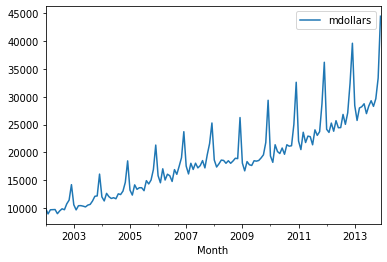

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression


revenue_df = pd.read_csv('https://user.informatik.uni-goettingen.de/~sherbold/online_and_mail_shopping.csv',
                        header = 0, parse_dates = [0], names = ['Month', 'mdollars'], index_col = 0)
revenue_df.plot()
plt.show()

The data looks like there is a linear trend a a seasonal pattern with a strong peak in December. This makes sense is likely due to the holiday season. We note that we see a drop in revenue at the end of 2008, which is likely due to the financial crisis. In our solution, we append more columns to our data frame that contain the intermediary results. If you are interested, you can modify this solution locally and output `revenue_df` to see the actual values of all steps.  

## Detrending and seasonal adjustment with regression and mean values

Detrend the data using a linear regression and then do a seasonal adjustment by removing the monthly mean values from the data. Visualize the effects of these adjustments.

We first detrend the data with linear regression.

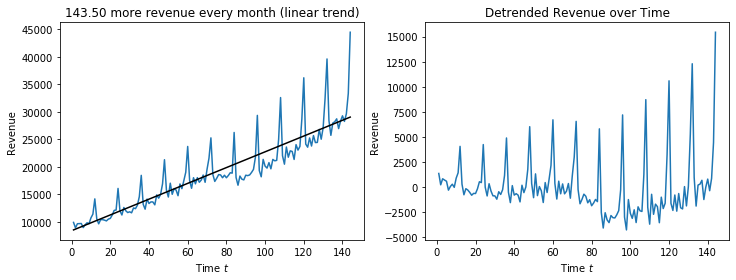

In [2]:
X = np.arange(1,revenue_df.shape[0]+1).reshape(-1, 1)
Y = revenue_df['mdollars'].values.reshape(-1, 1)

regr = LinearRegression()
ax = regr.fit(X, Y)
T_pred = regr.predict(X)[:,0]
revenue_df['mdollars_lin'] = revenue_df['mdollars']-T_pred

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('%.2f more revenue every month (linear trend)' % regr.coef_[0])
axes[0].plot(X, Y)
axes[0].plot(X, T_pred, color='black')
axes[0].set_xlabel('Time $t$')
axes[0].set_ylabel('Revenue')

axes[1].set_title('Detrended Revenue over Time')
axes[1].plot(X, revenue_df['mdollars_lin'])
axes[1].set_xlabel('Time $t$')
axes[1].set_ylabel('Revenue')
plt.show()

The seasonality seems to be yearly, hence, we now determine the monthly means.

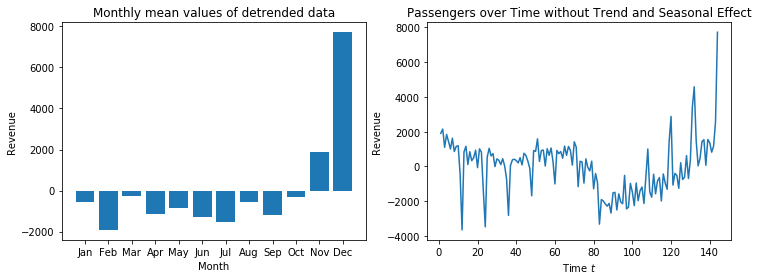

In [3]:
monthly_means = revenue_df['mdollars_lin'].groupby(revenue_df['mdollars_lin'].index.month).mean()

revenue_df['mdollars_lin_adj'] = revenue_df['mdollars_lin'] - np.tile(monthly_means,12)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Monthly mean values of detrended data')
axes[0].bar(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], monthly_means)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue')

axes[1].set_title('Passengers over Time without Trend and Seasonal Effect')
axes[1].plot(X, revenue_df['mdollars_lin_adj'])
axes[1].set_xlabel('Time $t$')
axes[1].set_ylabel('Revenue')
plt.show()

We observe the same problem we had with the air passengers data: the seasonal effect has an increasing trend and is therefore, not corrected correctly by the seasonal means. The values seem to fit around $t=70$, before that the seasonal effect is overcorrected, afterwards it is undercorrected. However, from this analysis we see that there is an average increase of avenue 143.50 millions dollars per month, and that there is an increase in revenue of 8000 million dollars in December, in comparison to the average. 

## Detrending and seasonal adjustment with differencing

Use first order differencing for detrending the data and do a monthly seasonal adjustment for the detrended data. Visualize the effects of these adjustments. 

We start with a first-order differencing, which should remove the linear trend from the time series. 

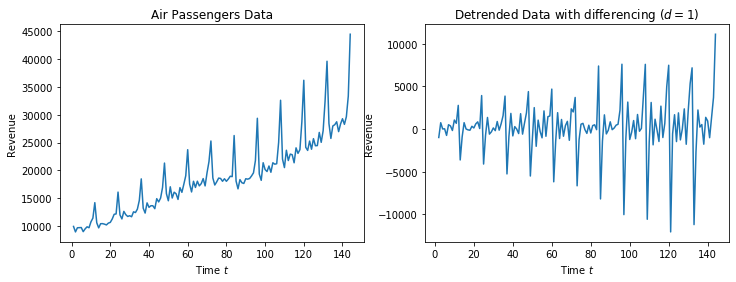

In [4]:
revenue_df['mdollars_diff'] = revenue_df['mdollars'].diff(1)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Air Passengers Data')
axes[0].plot(X, Y)
axes[0].set_xlabel('Time $t$')
axes[0].set_ylabel('Revenue')

axes[1].set_title('Detrended Data with differencing ($d=1$)')
axes[1].plot(X, revenue_df['mdollars_diff'])
axes[1].set_xlabel('Time $t$')
axes[1].set_ylabel('Revenue')
plt.show()

The trend seems to be compensated, but the yearly repeating seasonal affect is still clearly visible in the data. We remove this through seasonal differencing with a period of $s=12$. 

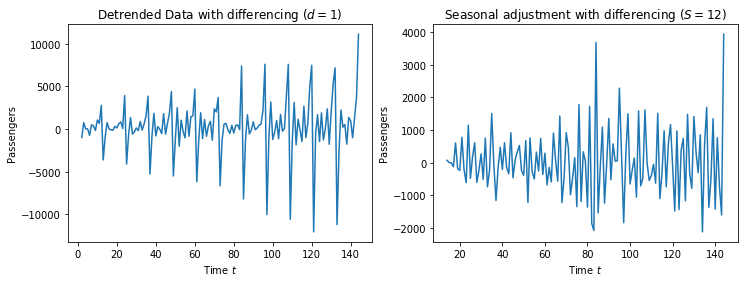

In [5]:
revenue_df['mdollars_diff_adj'] = revenue_df['mdollars_diff'].diff(periods=12)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].set_title('Detrended Data with differencing ($d=1$)')
axes[0].plot(X, revenue_df['mdollars_diff'])
axes[0].set_xlabel('Time $t$')
axes[0].set_ylabel('Passengers')

axes[1].set_title('Seasonal adjustment with differencing ($S=12$)')
axes[1].plot(X, revenue_df['mdollars_diff_adj'])
axes[1].set_xlabel('Time $t$')
axes[1].set_ylabel('Passengers')
plt.show()

The data now looks stationary, with a random fluctuation of a about 2000 million dollars. 

## Forecasting with ARMA

Fit an ARMA model with appropriate parameters $p$ and $q$ to the detrended and seasonal adjusted data (both versions) without the year 2013 (i.e., drop year 2013 for the model fitting). You can use plots of the autocorrelation and the partial autocorrelation for determining good values. Use the fitted models to forecast the values for the year 2013 and visualize the differences between the forecasted values and the actual values. You should do this with the actual values, i.e., including trend and seasonal effect. 

We start with determination of good values for $p$ and $q$ through the (partial) autocorrelation. 

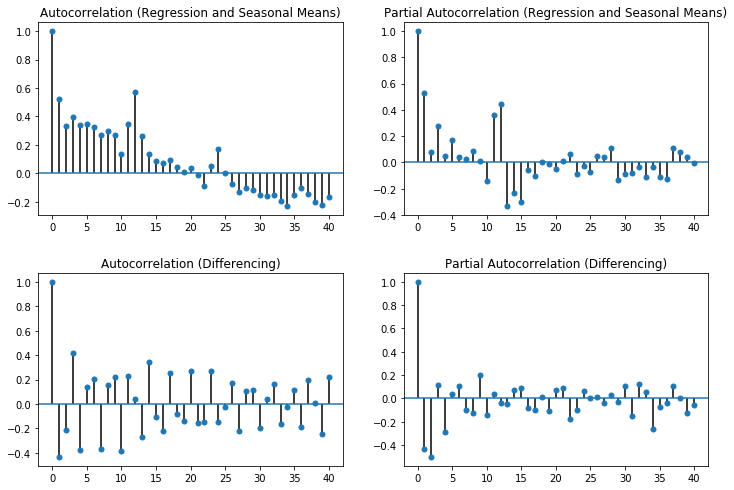

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7))

plot_acf(revenue_df['mdollars_lin_adj'], lags=40, alpha=None, ax=axes[0,0], title="Autocorrelation (Regression and Seasonal Means)")
plot_pacf(revenue_df['mdollars_lin_adj'], lags=40, alpha=None, ax=axes[0,1], title="Partial Autocorrelation (Regression and Seasonal Means)")
plot_acf(revenue_df['mdollars_diff_adj'].dropna(), lags=40, alpha=None, ax=axes[1,0], title="Autocorrelation (Differencing)")
plot_pacf(revenue_df['mdollars_diff_adj'].dropna(), lags=40, alpha=None, ax=axes[1,1], title="Partial Autocorrelation (Differencing)")
plt.subplots_adjust(left=None, bottom=0, right=None,
                top=None, wspace=None, hspace=0.3)
plt.show()

For the regression/seasonal mean approach, we select $p=15$, because there is still a direct correlation that has such a long effect. While this is a large model, this should be able to account for the residual seasonal effect that we have, because the seasonal mean approach cannot deal with trends in the season. While the autocorrelation does not tend towards zero until roughly 12 steps passed, it looks like the autocorrelation is largely stable and is likely explained by the carryover. Therefore, we use $q=1$. 

For the differencing, we select $0=2$, because afterwards there is only a very weak partial autocorrelation. Since the autocorrelation has a similar pattern to the partial autocorrelation, we assume that this is mostly explained by the partial autocorrelation and use $q=1$ as well. 

We now fit the ARMA models and predict the next twelve values. It is important that we undo the adjustments for trends and seasonality, if we want to look at the forecasts of the actual values of the time series. First, we have the results with regression/seasonal means.

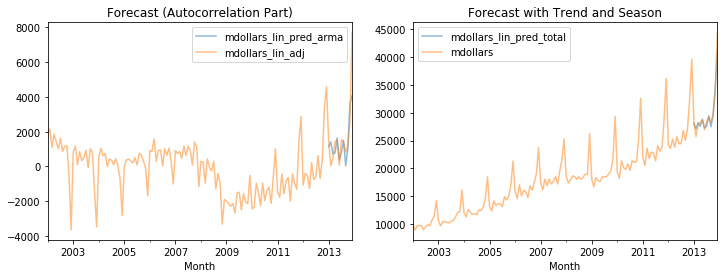

In [7]:
Y_train = revenue_df[revenue_df.index.year != 2013]['mdollars_lin_adj'].values

model = ARMA(Y_train, order=(15,1))
model_fit = model.fit(disp=0)

y_pred, _, _ = model_fit.forecast(steps=12)

# we must not forget to add the trend and the seasonal effect
y_pred_lin_adj = y_pred+T_pred[revenue_df.index.get_loc('2013-01-01'):]+monthly_means.values

revenue_df['mdollars_lin_pred_arma'] = np.NaN
revenue_df['mdollars_lin_pred_total'] = np.NaN
revenue_df.loc[revenue_df.index.year == 2013, 'mdollars_lin_pred_arma'] = y_pred
revenue_df.loc[revenue_df.index.year == 2013, 'mdollars_lin_pred_total'] = y_pred_lin_adj

fig, axes = plt.subplots(1,2,figsize=(12,4))
revenue_df[['mdollars_lin_pred_arma', 'mdollars_lin_adj']].plot(alpha=0.5, title='Forecast (Autocorrelation Part)', ax=axes[0])
revenue_df[['mdollars_lin_pred_total', 'mdollars']].plot(alpha=0.5, title='Forecast with Trend and Season', ax=axes[1])
plt.show()

We can see that, even though the time series was not fully stationary, we get a pretty good forecast that looks similar to the original time series. 

Now we look at the results with differencing.

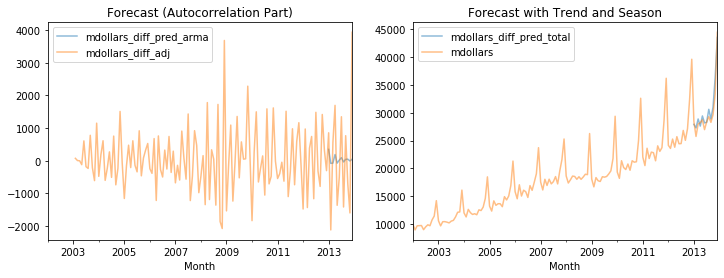

In [8]:
Y_train = revenue_df[revenue_df.index.year != 2013]['mdollars_diff_adj'].dropna().values

model = ARMA(Y_train, order=(2,1))
model_fit = model.fit(disp=0)

y_pred, _, _ = model_fit.forecast(steps=12)

y_pred_diff_adj = y_pred.copy()
# add season -> add values prior to seasonal adjustment
for i in range(0, 12):
    y_pred_diff_adj[i] += revenue_df.iloc[-24+i]['mdollars_diff'] # add value from last year of with seasonal effect
# add trend -> add values prior to differencing for trend
y_pred_diff_adj[0] += revenue_df.iloc[-13]['mdollars']
for i in range(1,12):
    y_pred_diff_adj[i] += y_pred_diff_adj[i-1]


revenue_df['mdollars_diff_pred_arma'] = np.NaN
revenue_df['mdollars_diff_pred_total'] = np.NaN
revenue_df.loc[revenue_df.index.year == 2013, 'mdollars_diff_pred_arma'] = y_pred
revenue_df.loc[revenue_df.index.year == 2013, 'mdollars_diff_pred_total'] = y_pred_diff_adj

fig, axes = plt.subplots(1,2,figsize=(12,4))
revenue_df[['mdollars_diff_pred_arma', 'mdollars_diff_adj']].plot(alpha=0.5, title='Forecast (Autocorrelation Part)', ax=axes[0])
revenue_df[['mdollars_diff_pred_total', 'mdollars']].plot(alpha=0.5, title='Forecast with Trend and Season', ax=axes[1])
plt.show()

This fit looks also very good, possibly even a bit better than the results with regression/seasonal means. We now compare both results directly, to see the differences. 

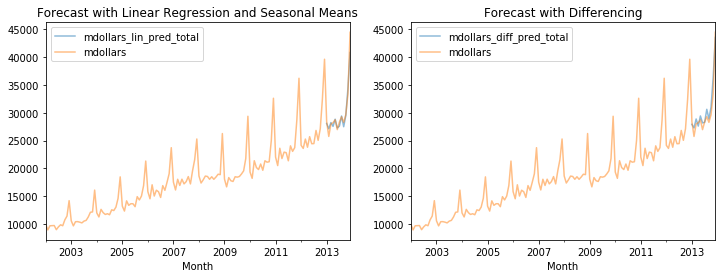

In [9]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
revenue_df[['mdollars_lin_pred_total', 'mdollars']].plot(alpha=0.5, title='Forecast with Linear Regression and Seasonal Means', ax=axes[0])
revenue_df[['mdollars_diff_pred_total', 'mdollars']].plot(alpha=0.5, title='Forecast with Differencing', ax=axes[1])
plt.show()

The biggest difference between both approaches is in the December and only very hard to see. In the left plot, the forecasts underestimates the value, while the forecast seems to be more accurate in the right plot. We can look at the actual values to see this more clearly.

In [10]:
revenue_df[['mdollars', 'mdollars_lin_pred_total', 'mdollars_diff_pred_total']][-12:]

,mdollars,mdollars_lin_pred_total,mdollars_diff_pred_total
Month,,,
2013-01-01,28437,28089.456420,27927.821215
2013-02-01,25749,27133.554203,27280.565331
2013-03-01,27988,28239.540599,28889.259821
2013-04-01,28218,27561.886687,27610.987986
2013-05-01,28748,28851.737765,29435.374495
2013-06-01,26975,27279.904719,28182.379343
2013-07-01,28349,27599.237646,28302.203822
2013-08-01,29297,29425.782976,30631.931348
2013-09-01,28283,27498.758768,28894.211671


This is likely still the undercorrection of the seasonal effect that we are seeing for the seasonal means. Thus, while both models work, we get slightly better results with the differencing. This is not surprising, because the approach can account for trends in the seasonality. 